# Combing data and analysing

The cleaned CSVs obtained from 1_extract_clk_data and 2_extract_ext_data can be combined and used to perform statistical analysis. This notebook does the following

* Joining external and clickstream data
* Adding new features and indices
* Filtering to a subset
* Performing some statistical analysis


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ttest_ind,pearsonr
from helper_files import checkLinearFit

# Inputs

external_csv = r"C:\Users\Andris\Documents\GitHub\data\clean\school_ext_data.csv"
internal_csv = r"C:\Users\Andris\Documents\GitHub\data\clean\school_clk_data.csv"


In [81]:
# ------------------------------------------------------
# JOIN EXTERNAL DATA WITH CLICKSTREAM DATA
# ------------------------------------------------------

# Read external data (indices and exam results)
df_ext = pd.read_csv(external_csv)

# Read internal data (clickstream data)
df_int = pd.read_csv(internal_csv)

# Combine the 2 dataframes
df_ext['URN'] = df_ext['URN'].astype('str') 
df = df_ext.set_index('URN').join(df_int.set_index('school_id'))

# ------------------------------------------------------
# ADDING NEW FEATURES AND INDICES
# ------------------------------------------------------

# Computing improvement in exam scores

qu = ['Biology','Mathematics','Chemistry','Physics']

for item in qu:
    df['exam_improv_' + item] = (df['exam_score|2016_'+item] - df['exam_score|2015_'+item]) - (df['exam_score|2016_'+item] - df['exam_score|2015_'+item]).mean()

# Teacher activity
df['teacher_activity'] = (df.filter(regex='q_lvl_[0-6]_tch|_cor_tch').sum(axis=1)/df['user_id_tch']).fillna(0)
df['teacher_other'] = (df[['add_user','create_group','add_custom_assig','add_assig','view_assig_prog']].sum(axis=1)/df['user_id_tch']).fillna(0)

# Student activity
df['student_activity'] =  (df.filter(regex='_cor_std').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)
df['student_other'] =  (df[['play_video_std','view_concept_std']].sum(axis=1)/df['Entries|2016_Physics']).fillna(0)

# ------------------------------------------------------
# CLEANING THE DATA
# ------------------------------------------------------

#  Remove all schools that have no IDACI rating
df = df[pd.notnull(df['IDACI'])]

#  All clickstream data that is not defined is set to 0
df = df.fillna(0)

# Select the schools that have provide all science courses in 2016
df = df[(df['Entries|2016_Biology']>0)&(df['Entries|2016_Physics']>0)&(df['Entries|2016_Chemistry']>0)&(df['Entries|2016_Mathematics']>0)]

# Select only those schools that also provide science courses in 2015
df = df[(df['Entries|2015_Biology']>0)&(df['Entries|2015_Physics']>0)&(df['Entries|2015_Chemistry']>0)&(df['Entries|2015_Mathematics']>0)]

# Remove any unecessary features
df = df.drop(df.filter(regex='Entries|exam_score'),axis=1)

# ------------------------------------------------------
# FURTHER CLEANING
# ------------------------------------------------------

# Creating another dataframe that has removed outliers (who fall outside the 95% percentile)
q = df[['teacher_activity','teacher_other','student_activity','student_other']].quantile(0.95)

df_out = df[(df[q.keys()] < q).all(axis=1)]

# Print dataframe features
print('Total number of schools (with outliers):',df.shape[0])
print('Total number of features (with outliers):',df.shape[1])

print('Total number of schools (no outliers):',df_out.shape[0])
print('Total number of features (no outliers):',df_out.shape[1])

# Print the first 5 rows of the dataframe
df.head(5)


Total number of schools (with outliers): 725
Total number of features (with outliers): 54
Total number of schools (no outliers): 646
Total number of features (no outliers): 54


,IDACI,Effectiveness,Teach_quality,L_M_index,PercentageFSM,q_lvl_2_cor_tch,view_concept_tch,q_lvl_3_cor_tch,q_lvl_2_tch,q_lvl_0_cor_tch,...,q_lvl_5_std,play_video_std,exam_improv_Biology,exam_improv_Mathematics,exam_improv_Chemistry,exam_improv_Physics,teacher_activity,teacher_other,student_activity,student_other
URN,,,,,,,,,,,,,,,,,,,,,
100049,5.0,3.0,3.0,3.0,40.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.243966,-0.117200,-0.058570,-0.173454,0.0,0.000000,0.000000,0.000000
100054,5.0,1.0,1.0,1.0,19.7,1.0,8.0,1.0,3.0,0.0,...,128.0,438.0,-0.075617,-0.063231,0.004101,-0.087845,6.5,16.000000,17.307692,11.871795
100190,4.0,2.0,2.0,2.0,20.7,12.0,7.0,0.0,15.0,0.0,...,0.0,0.0,0.005374,-0.019282,0.056830,0.013295,50.0,42.000000,0.000000,0.000000
100192,4.0,2.0,2.0,2.0,22.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.092524,-0.042368,-0.139522,-0.003901,0.0,0.000000,0.000000,0.000000
100279,4.0,2.0,2.0,2.0,21.2,3.0,2.0,10.0,6.0,28.0,...,0.0,262.0,0.088169,-0.027284,0.058434,0.077753,85.0,16.333333,20.812500,17.312500


## Statistical Analysis

Perform some statistical analysis on the dataset. This is seperated into 

* Evaluating correlation and their respective p values
* Evaluating difference in mean between 2 populations (active IP users and non-active users)

### Analysing correlations

Correlationg and their p values can be performed. Important things to note

* Correlation may be different according to method (Pearson, Kendall Tau or Spearman Rank).
* Outliers can affect correlation coefficient.
* The affect of IP may be radically different for different subsets. 


In [82]:
# Choose whether to incorporate outliers or not
df_test = df_out

df_test.corr(method='spearman')['exam_improv_Physics'].sort_values(ascending=False)


exam_improv_Physics        1.000000
exam_improv_Mathematics    0.369288
exam_improv_Chemistry      0.238870
exam_improv_Biology        0.117770
q_lvl_5_std                0.079535
q_lvl_6_cor_std            0.077544
q_lvl_5_cor_std            0.072286
q_lvl_0_cor_std            0.067555
q_lvl_0_std                0.066561
q_lvl_6_std                0.061553
Teach_quality              0.050635
q_lvl_4_std                0.045454
L_M_index                  0.043315
student_activity           0.039289
Effectiveness              0.038498
add_custom_assig           0.036898
q_lvl_4_cor_std            0.032611
play_video_tch             0.031069
q_lvl_5_tch                0.029300
q_lvl_3_cor_std            0.026225
view_hint_std              0.023510
create_group               0.022671
q_lvl_5_cor_tch            0.022020
user_id_std                0.020564
teacher_other              0.016842
q_lvl_0_tch                0.016352
view_assig_prog            0.014654
user_id_tch                0

In [83]:
# Calculating p values
feature_to_test = 'student_activity'

# Choose whether to incorporate outliers or not
df_test = df_out
print('No outliers')
print('For Biology:',pearsonr(df_test[feature_to_test],df_test['exam_improv_Biology']))
print('For Physics:',pearsonr(df_test[feature_to_test],df_test['exam_improv_Physics']))
print('For Maths:',pearsonr(df_test[feature_to_test],df_test['exam_improv_Mathematics']))
print('For Chem:',pearsonr(df_test[feature_to_test],df_test['exam_improv_Chemistry']))

# Choose whether to incorporate outliers or not
df_test = df
print('With outliers')
print('For Biology:',pearsonr(df_test[feature_to_test],df_test['exam_improv_Biology']))
print('For Physics:',pearsonr(df_test[feature_to_test],df_test['exam_improv_Physics']))
print('For Maths:',pearsonr(df_test[feature_to_test],df_test['exam_improv_Mathematics']))
print('For Chem:',pearsonr(df_test[feature_to_test],df_test['exam_improv_Chemistry']))

No outliers
For Biology: (0.0014928669593169271, 0.9697913057026688)
For Physics: (0.092258636183922008, 0.019008877405219289)
For Maths: (0.042955042402388198, 0.27564403691762235)
For Chem: (0.014775617970207157, 0.70778089243198128)
With outliers
For Biology: (-0.0059770768386319586, 0.87236004935235101)
For Physics: (0.0071926253748045349, 0.846696075766737)
For Maths: (0.059903395968809892, 0.10704626440758125)
For Chem: (-0.039882369786028098, 0.28352271394008671)


,Coef,R^2,X,Y,intercept
0,-0.000199,2.483888e-04,teacher_activity,exam_improv_Biology,-0.000192
1,0.000100,8.736896e-05,teacher_activity,exam_improv_Mathematics,-0.003631
2,-0.000341,7.411158e-04,teacher_activity,exam_improv_Chemistry,-0.004993
3,0.000264,2.609387e-04,teacher_activity,exam_improv_Physics,-0.004035
4,0.000083,7.691488e-05,teacher_other,exam_improv_Biology,-0.000910
5,0.000175,4.669814e-04,teacher_other,exam_improv_Mathematics,-0.003855
6,-0.000088,8.793185e-05,teacher_other,exam_improv_Chemistry,-0.005597
7,0.000687,3.127595e-03,teacher_other,exam_improv_Physics,-0.005239
8,0.000008,2.228652e-06,student_activity,exam_improv_Biology,-0.000738
9,0.000204,1.845136e-03,student_activity,exam_improv_Mathematics,-0.004691


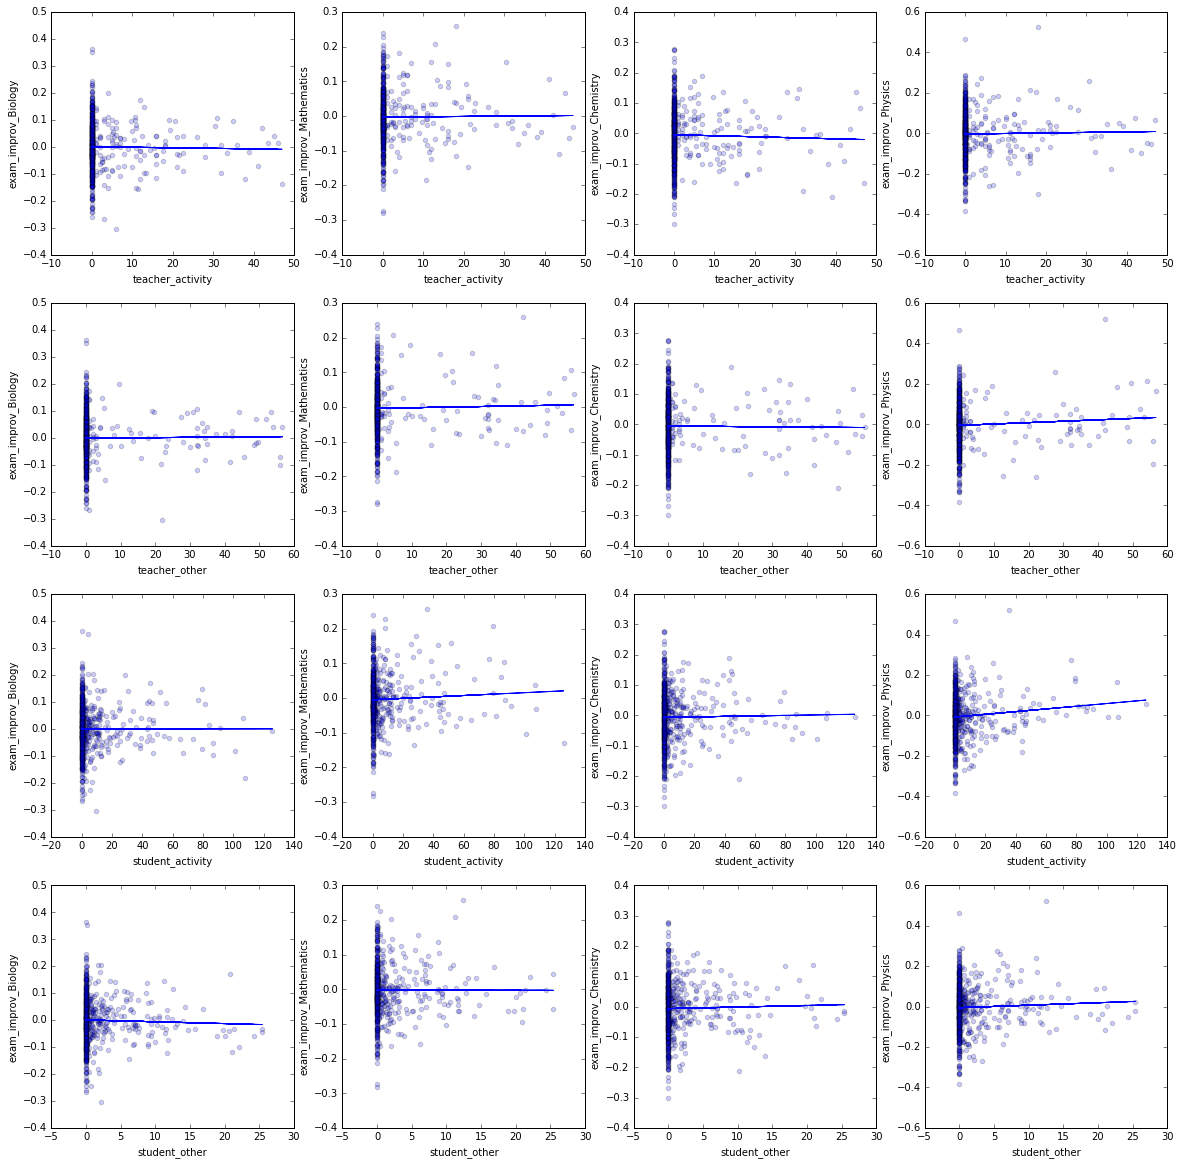

In [84]:
# Checking linear fit with no outliers

feature = ['teacher_activity','teacher_other','student_activity','student_other']

df_test = df_out

df_score = checkLinearFit(df_test,feature,df_test.filter(like='exam').columns, n_cols=4, n_rows=4,figsize=(20,20))
df_score

,Coef,R^2,X,Y,intercept
0,-0.000015,0.000173,teacher_activity,exam_improv_Biology,-0.000305
1,0.000015,0.000234,teacher_activity,exam_improv_Mathematics,-0.003365
2,-0.000027,0.000576,teacher_activity,exam_improv_Chemistry,-0.004443
3,0.000038,0.000669,teacher_activity,exam_improv_Physics,-0.002227
4,0.000017,0.000063,teacher_other,exam_improv_Biology,-0.000716
5,0.000036,0.000412,teacher_other,exam_improv_Mathematics,-0.003567
6,-0.000021,0.000103,teacher_other,exam_improv_Chemistry,-0.004590
7,0.000112,0.001711,teacher_other,exam_improv_Physics,-0.002968
8,-0.000003,0.000036,student_activity,exam_improv_Biology,-0.000432
9,0.000024,0.003588,student_activity,exam_improv_Mathematics,-0.003921


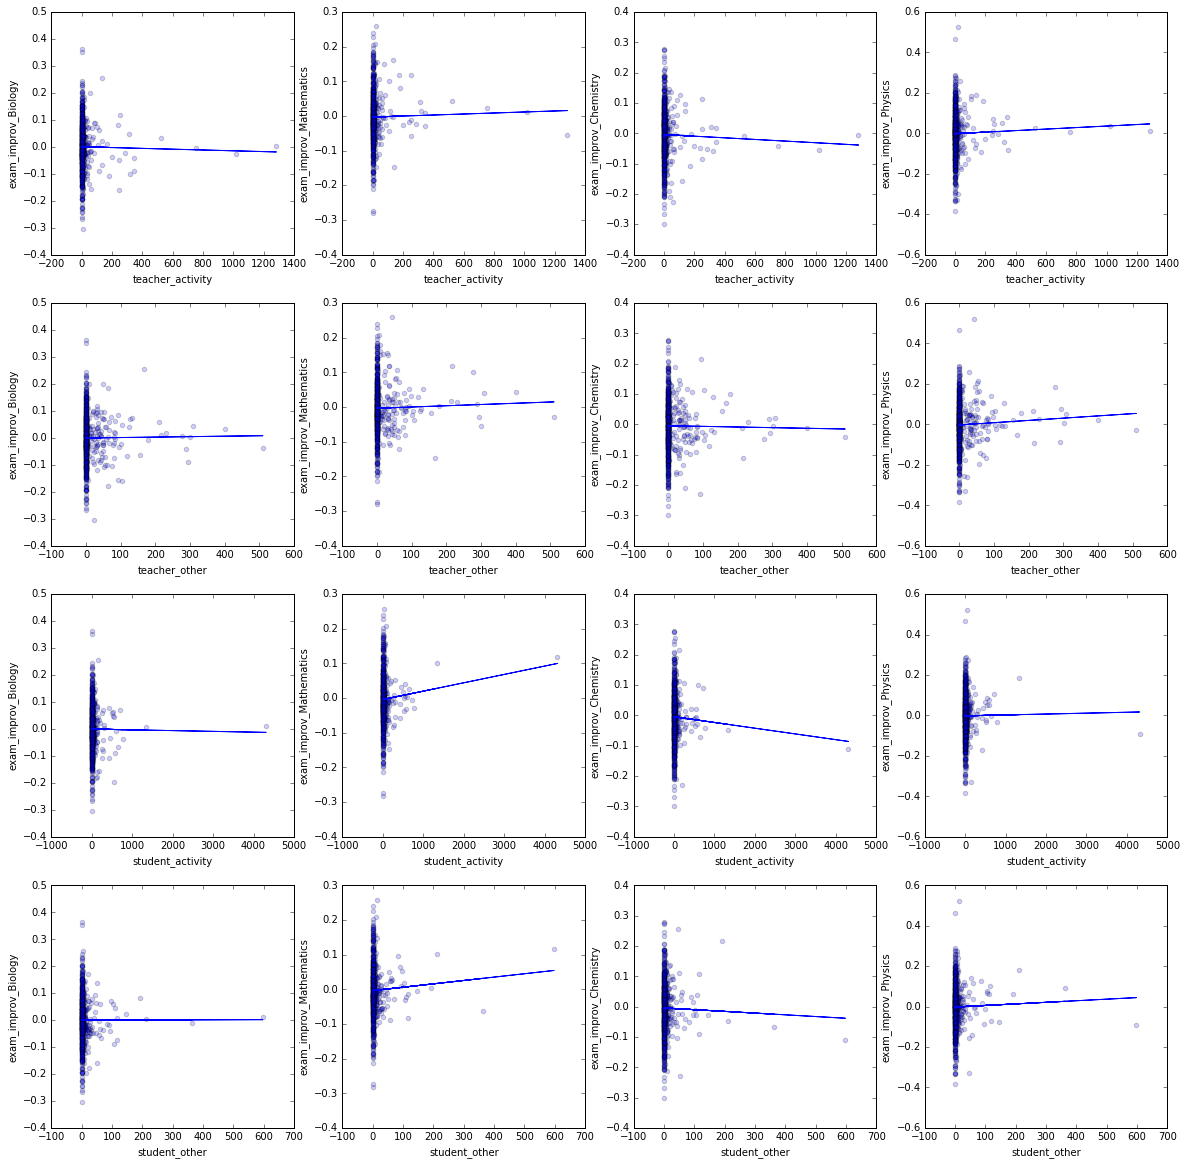

In [85]:
# Checking linear fit with outliers

feature = ['teacher_activity','teacher_other','student_activity','student_other']


df_score = checkLinearFit(df,feature,df.filter(like='exam').columns, n_cols=4, n_rows=4,figsize=(20,20))
df_score

## Analysing Populations

The schools can be binned into 2 seperate populations as active users, non-active users and semi-active users. 
Then the mean difference between the populations can be evaluated with an ANOVA test.  



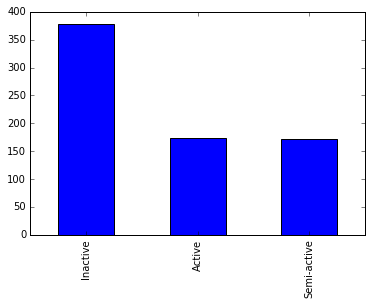

In [88]:
# Bin the schools into seperate categories

def bin_groups(df, feature, bins, group_names):
    
    categories = pd.cut(df[feature],bins, labels=group_names)
    return categories


# ------------------------------------------------------
# Choose a feature and determine distribution
# ------------------------------------------------------

bins = [-0.1, 0, 10,1000]
group_names = ['Inactive','Semi-active','Active']

df['categories'] = bin_groups(df,'student_activity',bins,group_names)

# Plot a histogram
df['categories'].value_counts().plot(kind='bar')



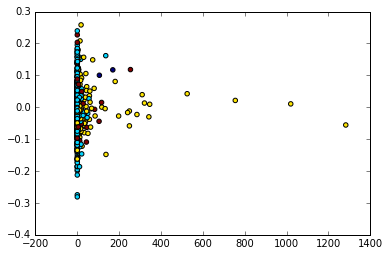

In [92]:
# Plotting a scatter plot to visualise any clusters

colors = pd.factorize(df['categories'])[0]
plt.scatter(df['teacher_activity'],df['exam_improv_Mathematics'],c=colors)

Mean of inactive: -0.008012451005084863
Mean of active: 0.011392602386698633


Ttest_indResult(statistic=-1.918329702862136, pvalue=0.05579959745770887)

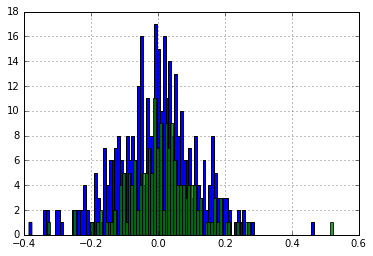

In [93]:
# Plot the histograms of the 2 populations and do a t-test

feature = 'exam_improv_Physics'

df[df['categories']=='Inactive'][feature].hist(bins=100)
df[df['categories']=='Active'][feature].hist(alpha=0.8,bins=100)

print('Mean of inactive:',df[df['categories']=='Inactive'][feature].mean())
print('Mean of active:',df[df['categories']=='Active'][feature].mean())

ttest_ind(df[df['categories']=='Inactive'][feature],df[df['categories']=='Active'][feature],equal_var=False)


In [94]:
# Doing an F-test on all variables of interest

from sklearn.feature_selection import f_classif


df_test = df[df['categories']!= 'Semi-active']

X = df_test.filter(regex='exam_improv')
y = [1 if item == 'Active' else 0 for item in df_test['categories']]
print('Keys:',X.keys())
F, pval = f_classif(X, y)
print('F score is ',F)
print('Corresponding p values',pval)

Keys: Index(['exam_improv_Biology', 'exam_improv_Mathematics',
       'exam_improv_Chemistry', 'exam_improv_Physics'],
      dtype='object')
F score is  [ 0.09457953  0.42206497  1.79805487  3.1553733 ]
Corresponding p values [ 0.75855022  0.51617919  0.18050034  0.07622911]


In [64]:
q = df[['teacher_activity','teacher_other','student_activity','student_other']].quantile(0.95)
